# Background



A large technology firm needs your help- they've been hacked! Luckily their forensic engineers have grabbed valuable data about the hacks, including information like session time,locations, wpm typing speed, etc. The forensic engineer relates to you what she has been able to figure out so far, she has been able to grab meta data of each session that the hackers used to connect to their servers. These are the features of the data:

* Session_Connection_Time': How long the session lasted in minutes
* Bytes Transferred: Number of MB transferred during session
* Kali_Trace_Used: Indicates if the hacker was using Kali Linux
* Servers_Corrupted: Number of server corrupted during the attack
* Pages_Corrupted: Number of pages illegally accessed
* Location: Location attack came from (Probably useless because the hackers used VPNs)
* WPM_Typing_Speed: Their estimated typing speed based on session logs.


The technology firm has 3 potential hackers that perpetrated the attack. They're certain of the first two hackers but they aren't very sure if the third hacker was involved or not. They have requested your help! Can you help figure out whether or not the third suspect had anything to do with the attacks, or was it just two hackers? 

**One last key fact, the forensic engineer knows that the hackers trade off attacks. Meaning they should each have roughly the same amount of attacks. For example if there were 100 total attacks, then in a 2 hacker situation each should have about 50 hacks, in a three hacker situation each would have about 33 hacks. The engineer believes this is the key element to solving this, but doesn't know how to distinguish this unlabeled data into groups of hackers.**

Let's start by starting a new Spark sesison and importing the required libaries 

In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler,PCA
from pyspark.sql.functions import udf,  monotonically_increasing_id, format_number, col
from pyspark.sql.types import FloatType
import pandas as pd
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName('Hack').getOrCreate()

In [11]:
hack_data = spark.read.csv("/user/a208669/hack_data.csv",header=True,inferSchema=True)

Let's have a look at the fields and some of the data

In [12]:
hack_data.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [13]:
hack_data.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [14]:
cols = [x for x in hack_data.columns if x != 'Location']

In [20]:
summary_data = hack_data.select(cols).describe()
summary_data.select(summary_data['summary'],*(format_number(col(c).cast("float"),2)\
                                                              .alias(c) for c in cols)).show()

+-------+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
|summary|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|WPM_Typing_Speed|
+-------+-----------------------+-----------------+---------------+-----------------+---------------+----------------+
|  count|                 334.00|           334.00|         334.00|           334.00|         334.00|          334.00|
|   mean|                  30.01|           607.25|           0.51|             5.26|          10.84|           57.34|
| stddev|                  14.09|           286.34|           0.50|             2.30|           3.06|           13.41|
|    min|                   1.00|            10.00|           0.00|             1.00|           6.00|           40.00|
|    max|                  60.00|         1,330.50|           1.00|            10.00|          15.00|           75.00|
+-------+-----------------------+---------------

Fortunately no missing data to deal with. Next we'll get the dat in the required format for Spark to work with

In [21]:
final_data  = VectorAssembler(inputCols=cols,outputCol = 'features').transform(hack_data)

We'll standaridize the data so that each variable has the same variance. This is to insure that one or more variable doesn't dominate the clustering solution

In [22]:
scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures',withMean=False,withStd=True)
final_data = scaler.fit(final_data).transform(final_data)

In [23]:
final_data.select('features','scaledFeatures').show()

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[8.0,391.09,1.0,2...|[0.56785108466505...|
|[20.0,720.99,0.0,...|[1.41962771166263...|
|[31.0,356.32,1.0,...|[2.20042295307707...|
|[2.0,228.08,1.0,2...|[0.14196277116626...|
|[20.0,408.5,0.0,3...|[1.41962771166263...|
|[1.0,390.69,1.0,2...|[0.07098138558313...|
|[18.0,342.97,1.0,...|[1.27766494049636...|
|[22.0,101.61,1.0,...|[1.56159048282889...|
|[15.0,275.53,1.0,...|[1.06472078374697...|
|[12.0,424.83,1.0,...|[0.85177662699757...|
|[15.0,249.09,1.0,...|[1.06472078374697...|
|[32.0,242.48,0.0,...|[2.27140433866020...|
|[23.0,514.54,0.0,...|[1.63257186841202...|
|[9.0,284.77,0.0,3...|[0.63883247024818...|
|[27.0,779.25,1.0,...|[1.91649741074455...|
|[12.0,307.31,1.0,...|[0.85177662699757...|
|[21.0,355.94,1.0,...|[1.49060909724576...|
|[10.0,372.65,0.0,...|[0.70981385583131...|
|[20.0,347.23,1.0,...|[1.41962771166263...|
|[22.0,456.57,0.0,...|[1.5615904

Firstly we'll make use of a k mean clustering algorithm with the number of clusters set equal to 3

In [24]:
kmeans = KMeans(featuresCol='scaledFeatures', k=3,seed=38298)

In [25]:
model = kmeans.fit(final_data)

The Within sum of squared errors is

In [27]:
print('wsse: {}'.format(model.computeCost(final_data)))

wsse: 434.1492898715845


Next we can calculate the number of attacks per cluster

In [30]:
results = model.transform(final_data).withColumn('row_index', monotonically_increasing_id())

In [31]:
results.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   84|
|         0|   83|
+----------+-----+



Looks like only 2 hackers were involved. Let's confirm it using Principal component analysis

In [40]:
prin_comp_model = PCA(k=3, inputCol="scaledFeatures", outputCol="pca")
pca_results = prin_comp_model.fit(final_data)


In [41]:
pca_results.explainedVariance

DenseVector([0.7238, 0.1668, 0.0521])

We see almost 90% of the variance in the data is explained by the first two prinicipal components. Let's get the principal vectors

In [42]:
data_with_pca =pca_results.transform(final_data)


In [43]:
data_with_pca.select('pca').show(n=10,truncate=False)

+--------------------------------------------------------------+
|pca                                                           |
+--------------------------------------------------------------+
|[0.03175378235005155,2.08479522367246,-1.1012050989195865]    |
|[-1.201851068618815,0.10296428435190434,-1.858161714809445]   |
|[-0.9909243808826815,2.0355570670115193,-0.34344645967896953] |
|[0.3404179776920393,2.0532259801189046,-0.7129220897841364]   |
|[-0.6258173324836158,0.06429338399282358,-0.8902629103290762] |
|[-0.04863120599925841,2.067856922427926,-1.1788881549277217]  |
|[-0.6287185401921063,2.050366188587716,-0.509283503240472]    |
|[-0.009233620615463511,2.0230469786739564,0.12794117643093939]|
|[-0.358021040905518,2.0387335121586,-0.45923815588743666]     |
|[-0.2914309910347539,2.0733098004622015,-1.0941732695889383]  |
+--------------------------------------------------------------+
only showing top 10 rows



In [172]:
data_with_pca.dtypes

[('Session_Connection_Time', 'double'),
 ('Bytes Transferred', 'double'),
 ('Kali_Trace_Used', 'int'),
 ('Servers_Corrupted', 'double'),
 ('Pages_Corrupted', 'double'),
 ('Location', 'string'),
 ('WPM_Typing_Speed', 'double'),
 ('features', 'vector'),
 ('scaledFeatures', 'vector'),
 ('pca', 'vector')]

We'll have to extract the first two principal component vectors from the pcs field (which currently is a vector)

In [44]:
split1_udf = udf(lambda value: value[0].item(), FloatType())
split2_udf = udf(lambda value: value[1].item(), FloatType())

First_2_comp = data_with_pca.select(split1_udf('pca').alias('pc1'), split2_udf('pca').alias('pc2'))\
                            .withColumn('row_index', monotonically_increasing_id())

In [46]:
First_2_comp.show()

+------------+-----------+---------+
|         pc1|        pc2|row_index|
+------------+-----------+---------+
| 0.031753782|  2.0847952|        0|
|   -1.201851| 0.10296428|        1|
| -0.99092436|   2.035557|        2|
|  0.34041798|   2.053226|        3|
| -0.62581736|0.064293385|        4|
|-0.048631206|   2.067857|        5|
| -0.62871855|  2.0503662|        6|
|-0.009233621|   2.023047|        7|
| -0.35802105|  2.0387335|        8|
| -0.29143098|    2.07331|        9|
|   -0.422941|   2.024986|       10|
|  -1.0058362|0.013882034|       11|
|  -0.8906927| 0.07624744|       12|
| -0.18611573|0.045908768|       13|
|  -1.1405135|  2.1226203|       14|
| -0.17657569|  2.0566304|       15|
| -0.14512442|  2.0731936|       16|
| -0.13912936|  0.0777961|       17|
| -0.22175823|  2.0670612|       18|
| -0.42366463| 0.08239772|       19|
+------------+-----------+---------+
only showing top 20 rows



Now we can join it back to the dataset containing the cluster assignment, by using the row index

In [47]:
results2= results.join(First_2_comp,on='row_index')

In [48]:
results2.select('prediction','pc1','pc2').show()

+----------+------------+-----------+
|prediction|         pc1|        pc2|
+----------+------------+-----------+
|         0| 0.031753782|  2.0847952|
|         2|   -1.201851| 0.10296428|
|         0| -0.99092436|   2.035557|
|         0|  0.34041798|   2.053226|
|         2| -0.62581736|0.064293385|
|         0|-0.048631206|   2.067857|
|         0| -0.62871855|  2.0503662|
|         0|-0.009233621|   2.023047|
|         0| -0.35802105|  2.0387335|
|         0| -0.29143098|    2.07331|
|         0|   -0.422941|   2.024986|
|         2|  -1.0058362|0.013882034|
|         2|  -0.8906927| 0.07624744|
|         2| -0.18611573|0.045908768|
|         0|  -1.1405135|  2.1226203|
|         0| -0.17657569|  2.0566304|
|         0| -0.14512442|  2.0731936|
|         2| -0.13912936|  0.0777961|
|         0| -0.22175823|  2.0670612|
|         2| -0.42366463| 0.08239772|
+----------+------------+-----------+
only showing top 20 rows



Lastly we convert the dataframe to a Pandas dataframe for ease of plotting

In [49]:
pandas_df = results2.toPandas()

/opt/anaconda2/envs/py345/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


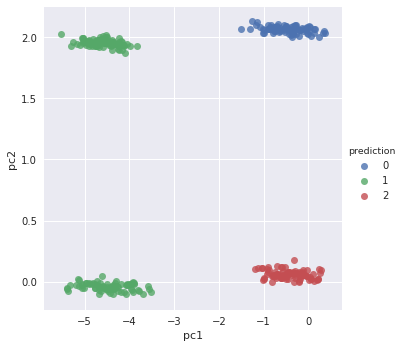

In [50]:
sns.plt.close()
sns.lmplot(x="pc1", y="pc2",data=pandas_df,fit_reg=False,hue="prediction")
sns.plt.show()

So there was either 4 hackers or we can trust the engineer's opinion that there were possibly only 2 hackers

In [52]:
kmeans2 = KMeans(featuresCol='scaledFeatures', k=2,seed=38298)
model2 = kmeans2.fit(final_data)

In [53]:
print('wsse: {}'.format(model2.computeCost(final_data)))

wsse: 601.7707512676716


In [54]:
results2 = model2.transform(final_data)

In [55]:
results2.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



Now we see that there is exactly the same number of observations in each of the 2 clusters, which confirms the engineer's premise that the hackers trade off attacks